In [18]:
import pandas as pd
import numpy as np 
df = pd.read_csv('./cnn_homework_dataset.csv')

In [19]:
#images 
k = lambda x :  np.asarray(x.split(" "),dtype = np.int32).reshape(48,48,1)
images = np.asarray(list(map(k,df['pixels'])))
target = df.drop(['img_name'],axis=1,inplace = False)
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   pixels     23705 non-null  object
dtypes: int64(3), object(1)
memory usage: 740.9+ KB


age: 1 
ethnicity: 2 
gender: 0 


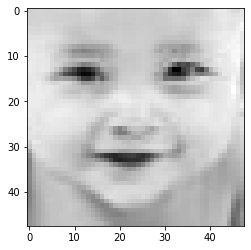

age: 92 
ethnicity: 2 
gender: 0 


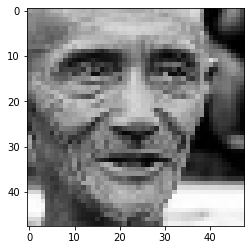

In [20]:
import matplotlib.pyplot as plt


plt.imshow(images[5],cmap="gray")
print("age: %d \nethnicity: %d \ngender: %d "%(target['age'][5],target['ethnicity'][5],target['gender'][5]))
plt.show()
plt.imshow(images[23662],cmap="gray")
print("age: %d \nethnicity: %d \ngender: %d "%(target['age'][23662],target['ethnicity'][23662],target['gender'][23662]))
plt.show()

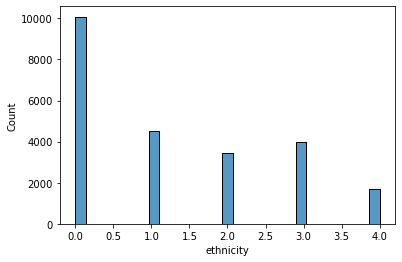

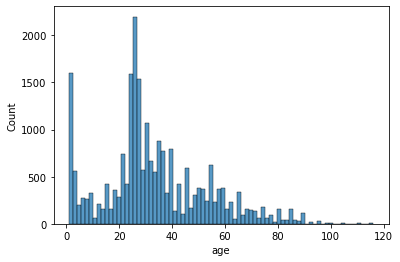

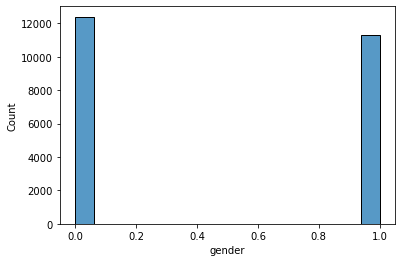

In [21]:
import seaborn as sns 

sns.histplot(target['ethnicity'])
plt.show()
sns.histplot(target['age'])
plt.show()
sns.histplot(target['gender'])
plt.show()
#plt.hist(target['ethnicity'],bins=8)


In [22]:
images = np.asarray(list(map(k,target['pixels'])))
target.drop(['pixels'],axis=1,inplace=True)

In [23]:
print(images.shape)
print(target.info())

(23705, 48, 48, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        23705 non-null  int64
 1   ethnicity  23705 non-null  int64
 2   gender     23705 non-null  int64
dtypes: int64(3)
memory usage: 555.7 KB
None


In [177]:
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow import keras
from keras import losses,metrics,optimizers
from tensorflow.keras import layers

print(target['age'].max())
print(target['age'].min())
print(target['ethnicity'].max())
print(target['ethnicity'].min())
a = np.asarray(tf.keras.utils.to_categorical(target['age'].tolist(),117),dtype=np.int32)
b = np.asarray(tf.keras.utils.to_categorical(target['ethnicity'].tolist(),5),dtype=np.int32)
c = np.asarray(target['gender']).reshape(-1,1)
X = images

116
1
4
0


In [172]:
#I tried training a model to predict age but due to the high variance it always reaches low accuracy
#I tried to split the data and teach diffrent models but the accuracy only goes up to 30
#So I'll be splitting it to categories
xa,ya = [],[]
for n,i in enumerate(target['age']):
    if i <= 18 :
        ya.append(0)
        xa.append(X[n])#catg0
    elif i>18 and i<=25 :
        ya.append(1)
        xa.append(X[n])#catg1
    elif i>25 and i<=35:
        ya.append(2)
        xa.append(X[n])#catg2
    elif i>35 and i<45 :
        ya.append(3)
        xa.append(X[n])#catg3
    else :
        ya.append(4)
        xa.append(X[n])#catg4

In [173]:
xa= np.asarray(xa)
ya= np.asarray(ya)

In [174]:
xa_train,xa_test, a_train,a_test = train_test_split(xa,ya,test_size=0.4, random_state=42,shuffle=True)
xa_val,xa_test, a_val,a_test = train_test_split(xa_test,a_test,test_size=0.8, random_state=42,shuffle=True)


In [178]:
xb_train,xb_test, b_train,b_test = train_test_split(X,b,test_size=0.4, random_state=42,shuffle=True)
xb_val,xb_test, b_val,b_test = train_test_split(xb_test,b_test,test_size=0.8, random_state=42,shuffle=True)

xc_train,xc_test, c_train,c_test = train_test_split(X,c,test_size=0.4, random_state=42,shuffle=True)
xc_val,xc_test, c_val,c_test = train_test_split(xc_test,c_test,test_size=0.8, random_state=42,shuffle=True)

In [86]:
Age_moldel = keras.Sequential([layers.Conv2D(32,5,padding='same',input_shape=(48, 48, 1),use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="random_normal",kernel_regularizer = keras.regularizers.l1(.00001)),
                               layers.LeakyReLU(),
                               layers.AveragePooling2D(padding="same",pool_size=(2,2)),
                               layers.Conv2D(64,3,padding='same',kernel_regularizer = keras.regularizers.l1(.0001)),
                               layers.LeakyReLU(),
                               layers.AveragePooling2D(padding="same",pool_size=(2,2)),
                               layers.Conv2D(64,3,padding='same',kernel_regularizer = keras.regularizers.l1(.0001)),
                               layers.LeakyReLU(),
                               layers.AveragePooling2D(padding="same",pool_size=(2,2)),
                               layers.Flatten(),
                               layers.Dense(100,kernel_regularizer = keras.regularizers.l1(.0001)),
                               layers.LeakyReLU(),
                               layers.Dropout(.9),
                               layers.Dense(50,kernel_regularizer = keras.regularizers.l1(.0001)),
                               layers.LeakyReLU(),
                               layers.Dropout(.9),
                               layers.Dense(5,activation="softmax")])

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

Age_moldel.compile(loss = losses.SparseCategoricalCrossentropy(),  
   optimizer =tf.keras.optimizers.Adam(lr) , metrics = [metrics.SparseCategoricalAccuracy()])
age_his = Age_moldel.fit(xa_train,a_train,epochs = 150 ,validation_data=(xa_val, a_val),batch_size=32,callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

Epoch 1/150
445/445 [==============================] - 20s 43ms/step - loss: 5.3425 - sparse_categorical_accuracy: 0.2295 - val_loss: 2.3452 - val_sparse_categorical_accuracy: 0.3370
Epoch 2/150
445/445 [==============================] - 19s 44ms/step - loss: 2.4943 - sparse_categorical_accuracy: 0.2691 - val_loss: 2.3141 - val_sparse_categorical_accuracy: 0.3365
Epoch 3/150
445/445 [==============================] - 19s 43ms/step - loss: 2.4135 - sparse_categorical_accuracy: 0.2853 - val_loss: 2.2916 - val_sparse_categorical_accuracy: 0.3365
Epoch 4/150
445/445 [==============================] - 19s 44ms/step - loss: 2.3611 - sparse_categorical_accuracy: 0.2927 - val_loss: 2.2582 - val_sparse_categorical_accuracy: 0.3365
Epoch 5/150
445/445 [==============================] - 19s 44ms/step - loss: 2.3200 - sparse_categorical_accuracy: 0.3025 - val_loss: 2.2188 - val_sparse_categorical_accuracy: 0.3365
Epoch 6/150
445/445 [==============================] - 19s 44ms/step - loss: 2.2529 -

In [188]:
Age_moldel1 = keras.Sequential([layers.Conv2D(32,3,padding='same',input_shape=(48, 48, 1),use_bias=True,kernel_initializer="HeNormal",bias_initializer="HeNormal",kernel_regularizer = keras.regularizers.l1(.00001)),
                               layers.LeakyReLU(),
                               layers.AveragePooling2D(padding="same",pool_size=(2,2)),
                               layers.Conv2D(64,3,padding='same',kernel_regularizer = keras.regularizers.l1(.0001)),
                               layers.LeakyReLU(),
                               layers.AveragePooling2D(padding="same",pool_size=(2,2)),
                               layers.Conv2D(64,3,padding='same',kernel_regularizer = keras.regularizers.l1(.0001)),
                               layers.LeakyReLU(),
                               layers.AveragePooling2D(padding="same",pool_size=(2,2)),
                               layers.Flatten(),
                               layers.Dropout(.1),
                               layers.Dense(100,kernel_regularizer = keras.regularizers.l1(.0001)),
                               layers.LeakyReLU(),
                               layers.Dropout(.9),
                               layers.Dense(5,activation="softmax")])

lr1 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

Age_moldel1.compile(loss = losses.SparseCategoricalCrossentropy(),  
   optimizer = tf.keras.optimizers.Adam(lr1) , metrics = [metrics.SparseCategoricalAccuracy()])
age_his1 = Age_moldel.fit(xa_train,a_train,epochs = 20 ,validation_data=(xa_val, a_val),batch_size=256,verbose=0)

Epoch 1/20
56/56 [==============================] - 17s 300ms/step - loss: 1.1257 - sparse_categorical_accuracy: 0.6307 - val_loss: 1.0943 - val_sparse_categorical_accuracy: 0.6345
Epoch 2/20
56/56 [==============================] - 17s 296ms/step - loss: 1.1012 - sparse_categorical_accuracy: 0.6387 - val_loss: 1.0738 - val_sparse_categorical_accuracy: 0.6292
Epoch 3/20
56/56 [==============================] - 17s 299ms/step - loss: 1.0954 - sparse_categorical_accuracy: 0.6338 - val_loss: 1.0740 - val_sparse_categorical_accuracy: 0.6361
Epoch 4/20
56/56 [==============================] - 17s 300ms/step - loss: 1.0872 - sparse_categorical_accuracy: 0.6403 - val_loss: 1.0835 - val_sparse_categorical_accuracy: 0.6345
Epoch 5/20
56/56 [==============================] - 17s 307ms/step - loss: 1.0787 - sparse_categorical_accuracy: 0.6402 - val_loss: 1.0723 - val_sparse_categorical_accuracy: 0.6382
Epoch 6/20
56/56 [==============================] - 18s 315ms/step - loss: 1.0715 - sparse_cate

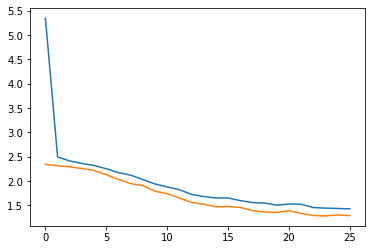

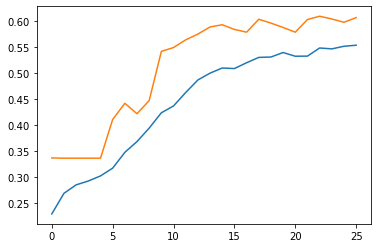

In [189]:
plt.plot(age_his.history['loss'])
plt.plot(age_his.history['val_loss'])
plt.show()
plt.plot(age_his.history['sparse_categorical_accuracy'])
plt.plot(age_his.history['val_sparse_categorical_accuracy'])
plt.show()

In [194]:
Age_moldel.evaluate(xa_test,a_test)

238/238 [==============================] - 3s 13ms/step - loss: 1.0740 - sparse_categorical_accuracy: 0.6391


[1.0740363597869873, 0.6390720009803772]

In [204]:
Age_moldel.save_weights('./Age_moldel.cpkt')

In [100]:
lr1 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)

Ethnicity_moldel = keras.Sequential([layers.Conv2D(32,4,padding='same',activation='tanh',kernel_regularizer = keras.regularizers.l1(.001),input_shape=(48, 48, 1),use_bias=True,kernel_initializer="glorot_normal",bias_initializer="zeros"),
                                    layers.AveragePooling2D(padding="valid",pool_size=(2,2)),
                                    layers.Conv2D(64,4,padding='same',activation='tanh',kernel_regularizer = keras.regularizers.l1(.001)),
                                    layers.AveragePooling2D(padding="valid",pool_size=(2,2)),
                                    layers.Conv2D(64,4,padding='same',activation='tanh',kernel_regularizer = keras.regularizers.l1(.001)),
                                    layers.Flatten(),
                                    layers.Dropout(.1),
                                    layers.BatchNormalization(),
                                    layers.Dense(90,activation='tanh',kernel_regularizer = keras.regularizers.l1(.01)),
                                    layers.Dropout(.1),
                                    layers.BatchNormalization(),
                                    layers.Dense(5,activation="softmax")])
   
Ethnicity_moldel.compile(loss = losses.CategoricalCrossentropy(),  
   optimizer = tf.keras.optimizers.Adam(lr1) , metrics = [metrics.CategoricalAccuracy()])
eth_his = Ethnicity_moldel.fit(xb_train,b_train,epochs =125,validation_data=(xb_val, b_val),batch_size=32,verbose=0)

In [68]:
Ethnicity_moldel.evaluate(xb_test,b_test)

237/237 [==============================] - 4s 17ms/step - loss: 0.7560 - categorical_accuracy: 0.7737


[0.7559731006622314, 0.7736647129058838]

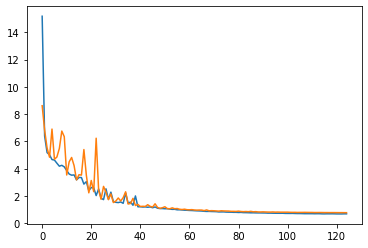

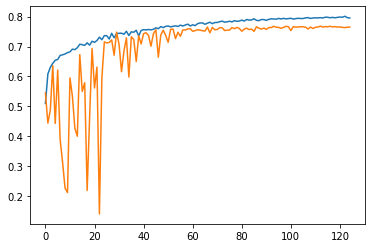

In [70]:
plt.plot(eth_his.history['loss'])
plt.plot(eth_his.history['val_loss'])
plt.show()
plt.plot(eth_his.history['categorical_accuracy'])
plt.plot(eth_his.history['val_categorical_accuracy'])
plt.show()

In [65]:
Ethnicity_moldel.save_weights('./Ethnicity.cpkt')

In [191]:
conv_1 = layers.Conv2D(32,3,padding='same',activation='relu',input_shape=(48, 48, 1),kernel_initializer="HeNormal",bias_initializer="zeros")
conv_2 = layers.Conv2D(64,3,padding='same',activation='relu')
conv_3 = layers.Conv2D(128,3,padding='same',activation='relu')

pooling_1 = layers.AveragePooling2D(padding="valid",pool_size=(2,2))

Dense_layer_1 = layers.Dense(150,activation="relu")
Dense_layer_2_2 = layers.Dense(1,activation="sigmoid")

Gender_moldel = keras.Sequential([conv_1,pooling_1,conv_2,pooling_1,conv_3,pooling_1,layers.Flatten(),layers.Dropout(.2),Dense_layer_1,layers.Dropout(.2),Dense_layer_2_2])
Gender_moldel.compile(loss = losses.BinaryCrossentropy(),  
   optimizer = "adam" , metrics = [metrics.BinaryAccuracy()])

gend_his = Gender_moldel.fit(xc_train,c_train,epochs = 120 ,validation_data=(xc_val, c_val),callbacks = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=2),verbose=0)


In [66]:
Gender_moldel.save_weights('./Gender.cpkt')

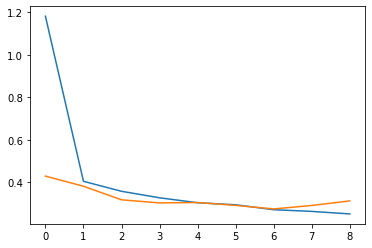

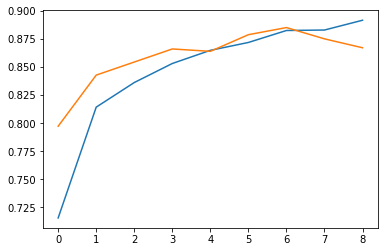

In [32]:
plt.plot(gend_his.history['loss'])
plt.plot(gend_his.history['val_loss'])
plt.show()
plt.plot(gend_his.history['binary_accuracy'])
plt.plot(gend_his.history['val_binary_accuracy'])
plt.show()

In [31]:
Gender_moldel.evaluate(xc_test,c_test)

237/237 [==============================] - 4s 19ms/step - loss: 0.2854 - binary_accuracy: 0.8828


[0.2854190170764923, 0.8828001022338867]

In [197]:
def Model(image):
    return'Age Category: {} \nGender: {} \nEthnicity: {}'.format(np.argmax(Age_moldel.predict(image.reshape(-1,48,48,1))),np.argmax(Gender_moldel.predict(image.reshape(-1,48,48,1))),np.argmax(Ethnicity_moldel.predict(image.reshape(-1,48,48,1))))

predicted :
1/1 [==============================] - 0s 16ms/step
Age Category: 0 
Gender: 0 
Ethnicity: 0


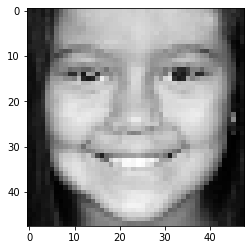

real :
14
0
4 

predicted :
1/1 [==============================] - 0s 12ms/step
Age Category: 0 
Gender: 0 
Ethnicity: 2


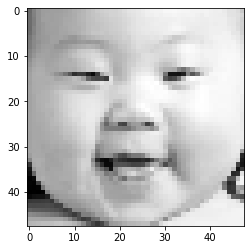

real :
1
0
2 

predicted :
1/1 [==============================] - 0s 13ms/step
Age Category: 0 
Gender: 0 
Ethnicity: 2


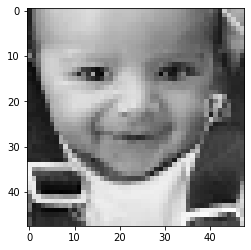

real :
1
0
3 

predicted :
1/1 [==============================] - 0s 14ms/step
Age Category: 2 
Gender: 0 
Ethnicity: 3


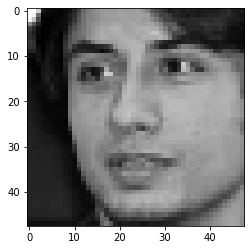

real :
24
0
3 



In [203]:
for j in [1618,15,42,4845] :
    print("predicted :")
    print(Model(images[j]))
    plt.imshow(images[j],cmap="gray")
    plt.show()
    print("real :")
    print(np.argmax(a[j]))
    print(np.argmax(c[j]))
    print(np.argmax(b[j]),'\n')
  